In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#The training was done on Kaggle and after that the notbook was transferred into colab 
# in order to test the camera script #


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import cv2
from sklearn import preprocessing
from keras.utils import np_utils
import tensorflow as tf
from sklearn.model_selection import train_test_split

**First we need to read our dataset into a dataframe which 
we do below.After that w define a function to read the image from the string format
into 'image' compatible with the patplotlib library and with size (48,48) in grayscales we can show the image** .

In [ ]:
faces = pd.read_csv('/content/drive/MyDrive/MACHINE_LEARNING_2/DATA/fer2013.csv')

1


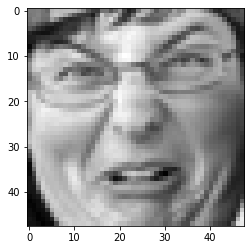

In [ ]:
#function to read sample and transform it to numpy array to show it as image
#takes array y and index of sample k 
def stringToImageArray(y,k):
    image =  np.array([float(x) for x in (list(y.iloc[k].split(' ')))]).reshape(-1,1)
    #print(image.dtype)
    image_2d = np.reshape(image,(48,48))
    #print(image_2d.dtype)
    plt.imshow(image_2d,cmap='gray')

    
#run function 
stringToImageArray(faces['pixels'],299)
print(faces['emotion'][299])


Next we count the different classes that exist in the dataset and we create a dictionary to map an integer (0.6) to each 'emotion' class.This will be utilized every time we have a result with class n and we need to get it's corresponding emotion.

In [ ]:
#get info for dataset
print(faces.describe())
print(faces.head())
#see the unique classes
print('\n\n The classes we need to recognise are : ' + str(list(faces.emotion.unique())) + '\n')

            emotion
count  35887.000000
mean       3.323265
std        1.873819
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


 The classes we need to recognise are : [0, 2, 4, 6, 3, 5, 1]



In [ ]:
#create dictionary to map facial expressions to indexes 
# we see from the original dataset that this is the labeling of the images so we follow this labeling schema
emotion_dict = {0:'anger',
                1:'disgust',
                2:'fear',
                3:'happiness',
                4:'sadness',
                5:'surprise',
                6:'neutral' }

**Also important is the fact that we need to transform each image into a 3d Tensor (n_samples,width,height,1) 
so we can feed deep neural network architectures , which take tensors as input.**

In [ ]:
#create function to transform images into 3D tensors (shape : samples,width,height)
def imageArray(dataset,width,height):
    img1 = dataset['pixels'][0][:]
    array_img1 = np.array([float(x) for x in (list(img1.split(' ')))])
    print(array_img1.shape)
    image_array  = np.zeros((dataset.shape[0],array_img1.shape[0],1))
    i=0
    for img in dataset['pixels'][:]:
        image_array[i] =  np.array([float(x) for x in (list(img.split(' ')))]).reshape(-1,1)
        i=i+1
    #reshape into tensor of 2d images 
    image_array2d = np.reshape(image_array,(len(dataset['pixels']),width,height))
    print(image_array2d.shape)
    
    return image_array2d

In [ ]:
#turn into tensors
image_array2d = imageArray(faces,48,48)

(2304,)
(35887, 48, 48)


Then of course we encode each class into a row of [000..1...] where the '1' corresponds to the classe's index and 0 to all the other classes.This is need in order to use the categorical cross entropy loss function (otherwise we can use the decoded classes i create later in combination with sparse categorical cross entropy)

In [ ]:
#function to encode the labels into one hot encoded classes [010...0]
from sklearn.preprocessing import LabelEncoder

def encodeClasses(faces): 
    le = LabelEncoder()
    img_labels = le.fit_transform(faces.emotion)
    img_labels = np_utils.to_categorical(img_labels)    
    print('\nClasses encoded to ' + str(list(le.classes_)) + '\n')
    print('\nShape of image_labels ' + str( img_labels.shape) + '\n')
    return img_labels , le

In [ ]:
image_labels,le = encodeClasses(faces)
print(image_labels)


Classes encoded to [0, 1, 2, 3, 4, 5, 6]


Shape of image_labels (35887, 7)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
#see the classes produced 
print(le.classes_)
mapped_classes = dict(zip(le.classes_,le.transform(le.classes_)))
print(mapped_classes)
#mapped_classes_rev = dict(zip(image_labels,le.inverse_transform(image_labels)))
#print(mapped_classes_rev)

[0 1 2 3 4 5 6]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### We split the dataset into training , validation , test set and leave the test set outside of training in order to test in in the application in the end when we stop training.We use 75% of total samples for training and 25% for validation and testing .Then we split this validation dataset assigning 90% to validation and 10% to testing.This way we can get independent test , validation and training datasets.We also want the training and validation datasets to have similar ratio of class representation se we use the stratify option .

In [ ]:
#split into training and validation set and test set 
x_train,x_val1,y_train,y_val1 = train_test_split(image_array2d,image_labels,train_size=0.75,random_state=42,stratify=image_labels)
x_val,x_test,y_val,y_test = train_test_split(x_val1,y_val1,train_size=0.9,random_state=42,stratify=y_val1)
#show the shapes 
x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape

((26915, 48, 48),
 (8074, 48, 48),
 (898, 48, 48),
 (26915, 7),
 (8074, 7),
 (898, 7))

Next we get the class frequency for each class and study if indeed the ratio is maintained in training as well as validation.

In [ ]:
def getClassesFreq(y):
    values,freq = np.unique(np.argmax(y,axis=1,out=None),return_counts=True)
    print(values)
    print(freq)
    return values,freq
    

#print the values and frequency
train_ret = getClassesFreq(y_train)
val_ret = getClassesFreq(y_val)
test_ret = getClassesFreq(y_test)

[0 1 2 3 4 5 6]
[3715  410 3841 6742 4558 3001 4648]
[0 1 2 3 4 5 6]
[1114  123 1152 2022 1367  901 1395]
[0 1 2 3 4 5 6]
[124  14 128 225 152 100 155]


<BarContainer object of 7 artists>

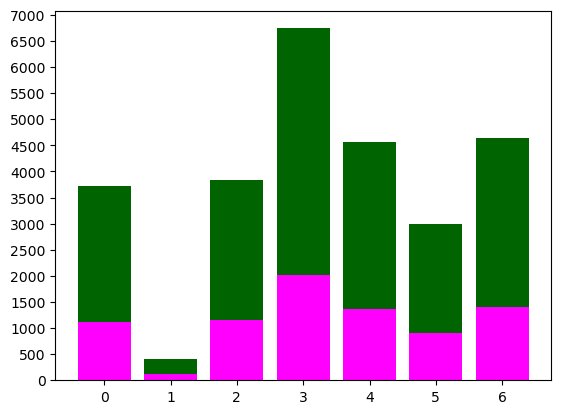

In [ ]:
plt.yticks(np.arange(0,7500,500))
plt.bar(train_ret[0],train_ret[1],color='darkgreen')
plt.bar(val_ret[0],val_ret[1],color='magenta')

<BarContainer object of 7 artists>

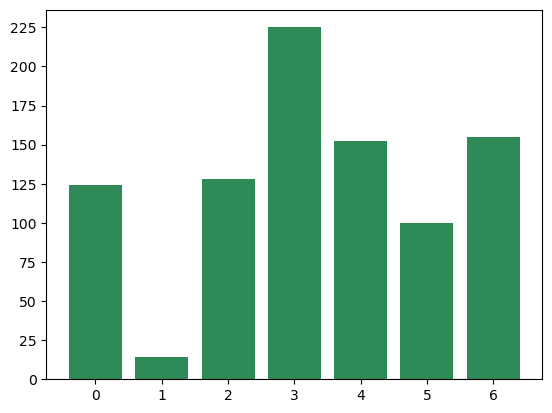

In [ ]:
plt.yticks(np.arange(0,250,25))
plt.bar(test_ret[0],test_ret[1],color='seagreen')

### We are certain now that the training - validation - test datasets are unbalanced so some classes are more dominant that others.From the bar plots we understand that class 3 is the most dominant (happy) followed by class 6(neutral) and 4(sadness).We will address this problem later.Also from the plots we can see we successfully have maintained the same classes frequency-imabalance in all the datasets using stratify.

In [ ]:
def plotImageWithClass(x,y):
    plt.figure()
    plt.text(4,8,str(list(y)),fontsize='x-large' )
    plt.imshow(x,cmap='gray')


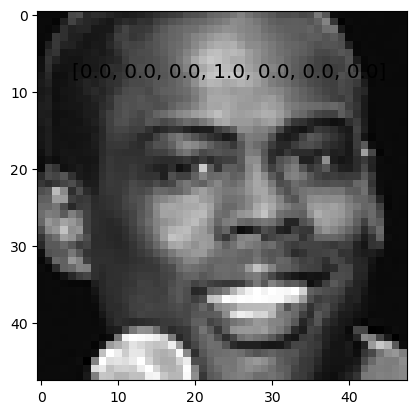

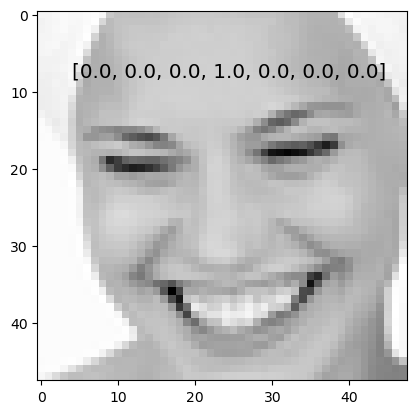

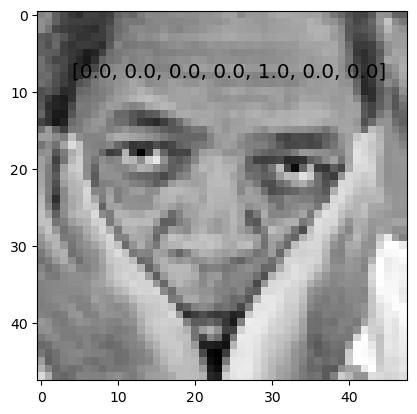

In [ ]:
#test show somw images with their classes 
plotImageWithClass(x_train[0],y_train[0])
plotImageWithClass(x_train[1],y_train[1])
plotImageWithClass(x_train[10],y_train[10])

We next normalize the pixels of the images to ensure that all of them have similar data distribution which helps 
in the convergence of deep neural networks architectures.We also avoid exploding dot products of weights with inputs 
since all the pixels (inputs) are in the ragne (0,1).

In [ ]:
#normalize images to get pixels in range (0,1)
x_train=x_train/255
x_val = x_val/255
x_test = x_test/255
print(x_train[0])


[[0.03529412 0.03529412 0.03529412 ... 0.03529412 0.03529412 0.03529412]
 [0.03921569 0.03921569 0.01960784 ... 0.03529412 0.03529412 0.03529412]
 [0.03921569 0.03137255 0.05490196 ... 0.03529412 0.03529412 0.03921569]
 ...
 [0.04313725 0.03921569 0.03921569 ... 0.49019608 0.49019608 0.55686275]
 [0.03921569 0.04313725 0.04313725 ... 0.48627451 0.50980392 0.5372549 ]
 [0.04313725 0.04313725 0.04313725 ... 0.49803922 0.51764706 0.5372549 ]]


In [ ]:
#set up width, height, depth, num_classes
width,height=x_train.shape[1],x_train.shape[2]
num_classes=y_train.shape[1]
print(width)
print(height)
print(num_classes)
print('#samples - training set : ',x_train.shape[0])
print('#samples - validation set : ',x_val.shape[0])
print('#samples - test set : ',x_test.shape[0])

48
48
7
#samples - training set :  26915
#samples - validation set :  8074
#samples - test set :  898


# BEGINNING MODELS

In [ ]:
#get the decoded class for each label (useful if sparse categorical cross entropy is going to be used)
def getDecodedLabels(y_t):
    y_decoded=[]
    for y in y_t:
        y_decoded.append(np.argmax(y, axis=0, out=None))
    y_decoded=np.array(y_decoded)
    print(y_decoded.shape)
    print(y_decoded)
    return y_decoded


In [ ]:
# decode y_train and y_val
y_train_decoded = getDecodedLabels(y_train)
y_val_decoded = getDecodedLabels(y_val)

(26915,)
[3 3 3 ... 5 0 3]
(8074,)
[5 6 0 ... 1 0 5]


In order to train a fully connected network we need 1 Dimensional vectors as inputs so we transform the images into 
1-D vectors (flattening) for this kind of architecture.

In [ ]:
# For fcn
# 1D flattened arrays
def flatten2DImageMatrix(x_t):
    x_flattened = []
    for x in x_t:
        x_flattened.append(x.flatten(order='C'))
    x_flattened = np.array(x_flattened)
    print(x_flattened.shape)
    return x_flattened


In [ ]:
#flatten x_train , x_val
x_train_flattened = flatten2DImageMatrix(x_train)
x_val_flattened = flatten2DImageMatrix(x_val)
x_test_flattened = flatten2DImageMatrix(x_test)

(26915, 2304)
(8074, 2304)
(898, 2304)


# **DNN IMPLEMENTATION**

# SIMPLE FCN MODEL

### **We will give the flattened images in the full connected network since it must receive the images as vectors**

(None, 2304)
<dtype: 'float32'>
(None, 128)
(None, 64)
(None, 32)
Model: "FCN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2304)]            0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 305,607
Trainable params: 305,607
Non-trainable params: 0
___________________________________________________

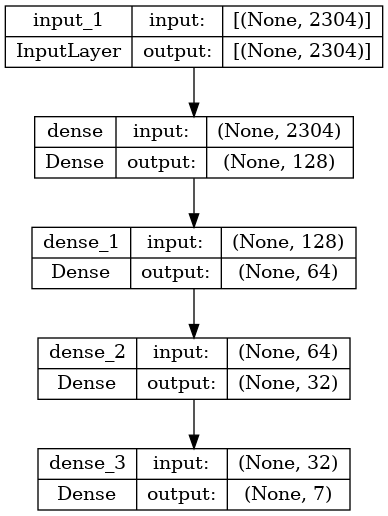

In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# design the DNN

#functional api 
#0
inputs = keras.Input(shape=(2304,))
print(inputs.shape)
print(inputs.dtype)
#1
dense_layer1 = layers.Dense(128,activation="sigmoid")
layer1_out = dense_layer1(inputs)
print(layer1_out.shape)

#2
dense_layer2 = layers.Dense(64,activation="sigmoid")
layer2_out = dense_layer2(layer1_out)
print(layer2_out.shape)

#3
dense_layer3 = layers.Dense(32,activation="sigmoid")
layer3_out = dense_layer3(layer2_out)
print(layer3_out.shape)


#3 final layer - output 
outputs = layers.Dense(7,activation = "softmax")(layer3_out)

#build model
fcn_model = keras.Model(inputs=inputs,outputs=outputs,name="FCN_model")
fcn_model.summary()
keras.utils.plot_model(fcn_model, "simple_fcn.png",show_shapes=True)


In [ ]:
#compile model
# we have one-hot encoded classes so we use categorical cross entropy 
# if i use the decoded integer classes we should use the sparse_categorical_cross_entropy
fcn_model.compile(
loss=keras.losses.CategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(),
metrics=["accuracy"]
)

history = fcn_model.fit(x_train_flattened,y_train,batch_size=256,epochs=60,verbose=2,validation_data=(x_val_flattened,y_val))

Epoch 1/60
106/106 - 2s - loss: 1.3688 - accuracy: 0.4829 - val_loss: 1.5642 - val_accuracy: 0.4069 - 2s/epoch - 20ms/step
Epoch 2/60
106/106 - 1s - loss: 1.3706 - accuracy: 0.4797 - val_loss: 1.5919 - val_accuracy: 0.4043 - 553ms/epoch - 5ms/step
Epoch 3/60
106/106 - 1s - loss: 1.3573 - accuracy: 0.4871 - val_loss: 1.5906 - val_accuracy: 0.3983 - 502ms/epoch - 5ms/step
Epoch 4/60
106/106 - 1s - loss: 1.3591 - accuracy: 0.4876 - val_loss: 1.5678 - val_accuracy: 0.4096 - 504ms/epoch - 5ms/step
Epoch 5/60
106/106 - 1s - loss: 1.3482 - accuracy: 0.4928 - val_loss: 1.5801 - val_accuracy: 0.3996 - 556ms/epoch - 5ms/step
Epoch 6/60
106/106 - 1s - loss: 1.3467 - accuracy: 0.4932 - val_loss: 1.6080 - val_accuracy: 0.3992 - 546ms/epoch - 5ms/step
Epoch 7/60
106/106 - 1s - loss: 1.3386 - accuracy: 0.4980 - val_loss: 1.5666 - val_accuracy: 0.4098 - 554ms/epoch - 5ms/step
Epoch 8/60
106/106 - 0s - loss: 1.3440 - accuracy: 0.4933 - val_loss: 1.6257 - val_accuracy: 0.3946 - 496ms/epoch - 5ms/step
Ep

We can see that the model achieves an accuracy close to 40% in the validation set.
Generally Fully connected networks  involve prediction at individual pixel level, 
thus requiring a dense layer with enormous number of parameters that needs to be learned.
This is very computationally demanding and can also lead to overfitting .Also the weights are not shared so the model is very inefficient.Due to the input
1-D vector representation FCNs are also more difficult to generalize and need very specific customization.In contrast to that
CNN models can be reused with minor changes and the shared between overlapping patches can be shared making them a better
choice for image classification.**Very important is also the fact that since we transform the image into a 1-D vector we lose neighboring pixels' informations which the CNN models take advantage in order to predict the classes , using sliding filters (kernels).**


**Next we create some functions to get the accuracy , loss and the confusion matrices for each model.** 

In [ ]:
#let's plot the accuracy and loss 
#create 2 functions for accuracy and losses

def getAccuracy(history,model_name):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name + ' model accuracy')
    plt.ylabel(model_name + ' accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def getLoss(history,model_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model_name + ' model loss')
    plt.ylabel(model_name + ' loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
#confusion matrix plot using sklearn 
from sklearn.metrics import confusion_matrix , f1_score , accuracy_score , recall_score , precision_score , precision_recall_curve ,ConfusionMatrixDisplay

#function to plot confusion matrix and return the result
def plotConfusionMatrix(y_true,y_pred,labels,Name):
    conf_matrix = confusion_matrix ( y_true, y_pred ,labels=labels,normalize='pred')
    #print(conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.title(Name)
    plt.show()
    return conf_matrix

#get prediction from dataset (x,y)
def getPrediction(model,x,y):
    #let's plot the confusion matrix to see the samples the model misclassified
    y_prediction = model.predict(x)
    #print(y_prediction)
    y_true = np.argmax (y, axis = 1)
    #print(y_true)
    y_pred=np.argmax(y_prediction, axis=1)
    #print(y_pred)
    return y_true,y_pred

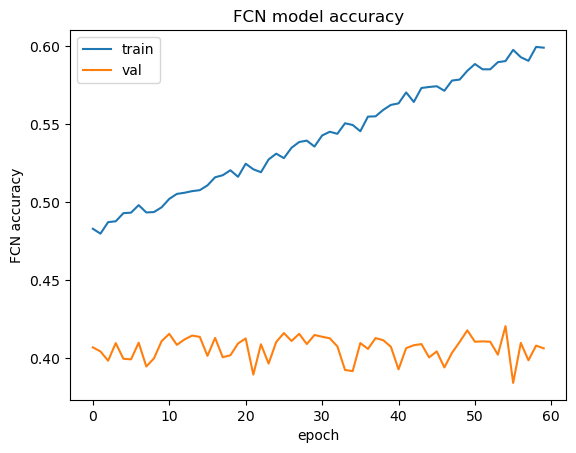

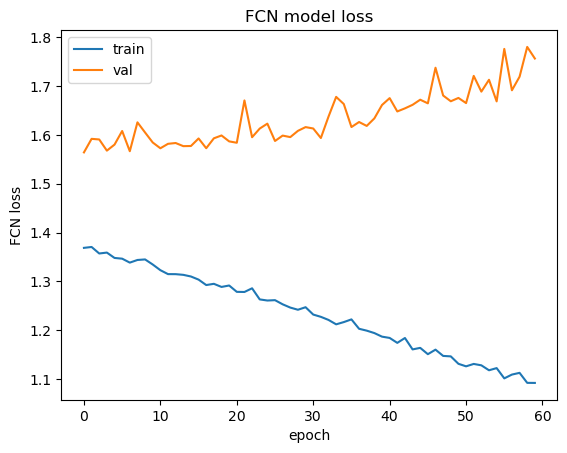

In [ ]:
getAccuracy(history,'FCN')
getLoss(history,'FCN')

We can see that the simple fully connected network begins to overfit after a while ,we get close to 0.4 accuracy.
From the loss curve we observe 'overfitting' on the training set .The fact that the loss can not be further reduced may be also attributed to the class imbalance , with which we will deal later in more appropriate models . Playing around with this model and adding or removing layers does not seem to produce better results or stable improvement ,as the model converges close to ~0.4. 

We will now build a convolutional deep neural network which is the prefered method for image classification , segmentation...and generally when working with images.Convolutional neural networks apply filters which slide along the images and produce feature maps.Yann LeCun‬ proposed the convolutional architecture which is based on shared-weights of the kernels that slide on the image and produce feature maps.These feature maps that are produced are then fed into more complext patterns and this way complex image features are learned .The models are trained using Back Propagation in supervised fashion and the final weights are those that actually encode the information of the features in the images .Cnn models can be invariant to translation and roation and we take advantage of these attributes in order to augment images and add variance into our training datasets.

Every cnn layer applied in forward pass in the model includes :
- convolution of the filter 
- activation using an activation function 
- some form of downsampling-pooling (average pooling/max pooling)

For the activation function **RELU f(z) = max(0,z)** will be used.The derivative of sigmoid **σ(x) x (1- σ(x))** has max 0.25 (<1) so in back propagation the final gradients that will update each weight can be so small since each time they multiply with each other,that they provide nominal updates to the weights in gradient descent ,making training very difficult and slow.In contrast to sigmoid/tanh functions , relu does not have the vanishing gradient problem as well it does not saturate.It is also easier for training of more complex architectures.

# SIMPLE CNN MODEL 

In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
import sklearn
from sklearn.model_selection import cross_val_score

**We begin by transforming the datasets into tensor datasets in order to feed the CNN.**

In [ ]:
#transform the images in 2d matrices (actually tensors of width x hight x 1)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1], x_train.shape[1],1))
print(x_train.shape)
x_val=np.reshape(x_val,(x_val.shape[0],x_val.shape[1],x_val.shape[1],1))
print(x_val.shape)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[1],1))
print(x_test.shape)

(26915, 48, 48, 1)
(8074, 48, 48, 1)
(898, 48, 48, 1)


Next we define a simple cnn class which has  1 input layer , 2 convolutional-relu-max pooling layers, 2 
fully connected layers and then we get the output.

In [ ]:
class CNN_SIMPLE:
        def __init__(self,input_shape,name,num_classes):
                self.inputs = keras.Input(shape=input_shape)
                conv_layer2 = layers.Conv2D(64,(5,5),strides=(1,1),padding='same',activation='relu',kernel_regularizer=None)
                self.layer2_outputs = conv_layer2(self.inputs)
                self.layer2b_outputs = layers.MaxPooling2D((2,2))(self.layer2_outputs)
                self.layer3_outputs = layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=None)(self.layer2b_outputs)
                self.layer3b_outputs = layers.MaxPooling2D((2,2))(self.layer3_outputs)
                self.outputs4 = layers.Flatten()(self.layer3b_outputs)
                self.outputs4b = layers.Dense(128,activation = "relu")(self.outputs4)
                self.outputs = layers.Dense(num_classes,activation = "softmax")(self.outputs4b)
                #self.im_name = name +'.png'
                
                
        def call(self):
                self.cnn_model = keras.Model(inputs=self.inputs,outputs=self.outputs)
                self.cnn_model.summary()
                return self.cnn_model

    


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0   

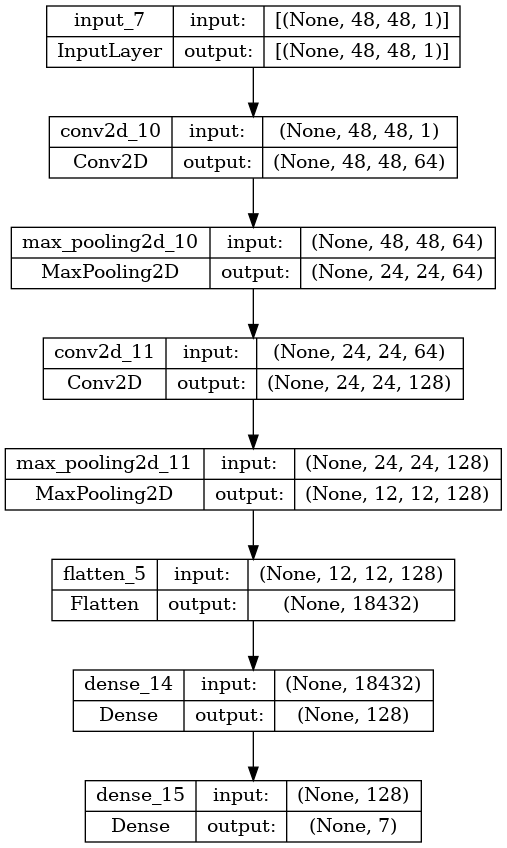

In [ ]:
#build first cnn model 
cnn1 = CNN_SIMPLE(input_shape=(48,48,1),name='CNN-1',num_classes=7).call()
keras.utils.plot_model(cnn1,to_file='cnn-1.png',show_shapes=True)

In [ ]:
# function to compile parameterized model

#remove old models 
#!rm -r /kaggle/working/cnn1.h5

def compileModel(loss,opt,metric,callba,model,batch_size,epochs,):
        model.reset_states()
        model.compile(
        loss=loss ,
        optimizer=opt , 
        metrics=metric 
        )
        cnn_callback1 = callba 
        cnn_history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(x_val,y_val),callbacks=cnn_callback1,shuffle=True,validation_freq=1)
        return cnn_history

In [ ]:
# run training and return history object 
cnn_history = compileModel(keras.losses.CategoricalCrossentropy(),
                  keras.optimizers.Adam(),
                  ["accuracy"],
                  [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1),
                  tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/cnn1.h5',save_best_only=True)],
                  cnn1,
                  32,
                  20
                 )

Epoch 1/20
842/842 - 13s - loss: 1.6318 - accuracy: 0.3573 - val_loss: 1.5015 - val_accuracy: 0.4266 - 13s/epoch - 15ms/step
Epoch 2/20
842/842 - 5s - loss: 1.3921 - accuracy: 0.4659 - val_loss: 1.3807 - val_accuracy: 0.4684 - 5s/epoch - 6ms/step
Epoch 3/20
842/842 - 5s - loss: 1.2667 - accuracy: 0.5159 - val_loss: 1.3206 - val_accuracy: 0.5033 - 5s/epoch - 6ms/step
Epoch 4/20
842/842 - 6s - loss: 1.1473 - accuracy: 0.5662 - val_loss: 1.3235 - val_accuracy: 0.5050 - 6s/epoch - 7ms/step
Epoch 5/20
842/842 - 6s - loss: 1.0239 - accuracy: 0.6183 - val_loss: 1.3356 - val_accuracy: 0.5188 - 6s/epoch - 7ms/step
Epoch 6/20
842/842 - 6s - loss: 0.8853 - accuracy: 0.6742 - val_loss: 1.3757 - val_accuracy: 0.5160 - 6s/epoch - 7ms/step
Epoch 7/20
842/842 - 5s - loss: 0.7437 - accuracy: 0.7309 - val_loss: 1.4829 - val_accuracy: 0.5214 - 5s/epoch - 6ms/step
Epoch 8/20
842/842 - 5s - loss: 0.6030 - accuracy: 0.7834 - val_loss: 1.6245 - val_accuracy: 0.5225 - 5s/epoch - 6ms/step
Epoch 8: early stoppi

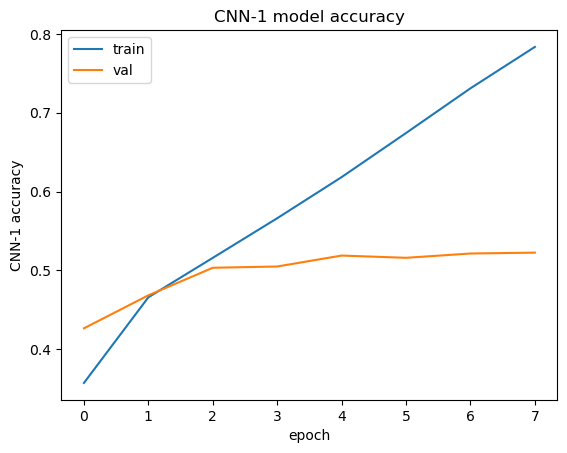

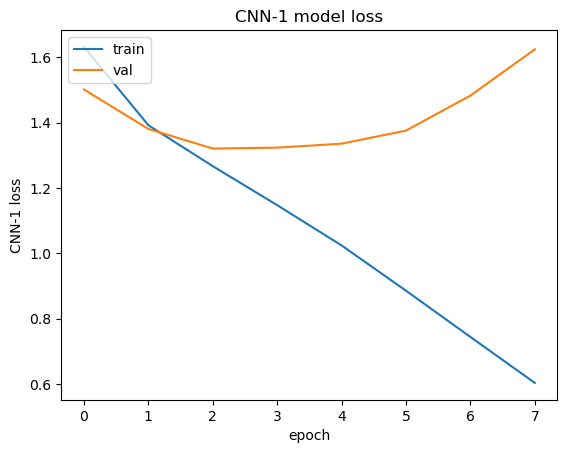

In [ ]:
getAccuracy(cnn_history,'CNN-1')
getLoss(cnn_history,'CNN-1')

We can see that the classification accuracy surpasses the simple fcn model but due to class imbalance and because we have not parameterized the model the accuracy is still low and the model begins to overfit after epoch 2-3.

We have class imbalance in which the overfitting is probably attributed to.We need to take care of this, using all or some of :
- augmentation of the dataset (rotation , flipping , reflections)
- adding new data 
and also we need to add :
- batch normalization
- regularization 
- dropout 
We can also experiment with :
- early stopping 
- parameterizing the learning_rate (use a scheduler to reduce it when metric does not improve)
- parameterizing the optimizer


For the next implementation we keep the same model but try to increase the data variety of the classes using 
a data generator (add rotated,flipped images) for the training set.We still apply early stopping and save the best model.

We use Adam Optimizer instead of Stochastic Gradient Descent since Adam 
is
- computationally efficient
- memory lightweight
- invariant to some gradient reshaping 
- well suited for problems that have large parameters/data

In [ ]:
cnn2 = CNN_SIMPLE(input_shape=(48,48,1),name='CNN-2',num_classes=7).call()
cnn2.compile(
loss=keras.losses.CategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
metrics=["accuracy"]
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 18432)             0   

In order to combat potential overfitting we apply an image data generator which 
produces artificial new data on the fly  from those existing in the original dataset through a variety of transformations :
- roation 
- width shift 
- height shift
- reflections 
- shearing 

In [ ]:

# add new data (augmented) of the classes in the dataset 
# we also reduce the learning rate when a plateu appears 
# augment also the training data
from tensorflow.keras.preprocessing import image

reduce_learn_rate=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, #0.2
    patience=5,
    verbose=1,
    min_lr=1e-10 #-7
)

train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.12,
    horizontal_flip=True,
    vertical_flip=True
)


cnn_callback2 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True,verbose=1),
                 tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/cnn2.h5',save_best_only=True),
                reduce_learn_rate]


In [ ]:
#!rm -r /kaggle/working/cnn2.h5
cnn2.reset_states()
cnn2_history = cnn2.fit(train_datagen.flow(x_train,y_train,batch_size=32),
             validation_data=(x_val, y_val),
             steps_per_epoch=len(x_train)/32 ,epochs=100,callbacks=cnn_callback2,verbose=1)



Epoch 1/100
841/841 [==============================] - 16s 19ms/step - loss: 1.3094 - accuracy: 0.4971 - val_loss: 1.2864 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3042 - accuracy: 0.5001 - val_loss: 1.2827 - val_accuracy: 0.5063 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 15s 18ms/step - loss: 1.3078 - accuracy: 0.5001 - val_loss: 1.2721 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 16s 19ms/step - loss: 1.3009 - accuracy: 0.5026 - val_loss: 1.2638 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 15s 18ms/step - loss: 1.3039 - accuracy: 0.5015 - val_loss: 1.2495 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 16s 19ms/step - loss: 1.2931 - accuracy: 0.5076 - val_loss: 1.2470 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

We can see that with this model and using the image data generator the accuracy improves since we get + 4% and we get close to 56.53%.On the other hand we stil have class imbalance so the model is limited on the variety of features it can learn.

Next we will try:
- more convolutional layers
- regularization
- dropout 
- batch normalization
and later we will try to address the class imbalance problem

In [ ]:
# get model accuracy 
getAccuracy(cnn2_history,'CNN-2')
getLoss(cnn2_history,'CNN-2')

253/253 [==============================] - 1s 3ms/step


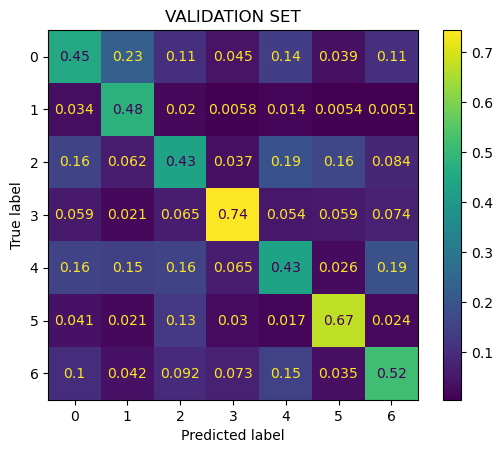

In [ ]:
# get production validation results
y_true,y_pred = getPrediction(cnn2,x_val,y_val)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'VALIDATION SET')

29/29 [==============================] - 0s 2ms/step


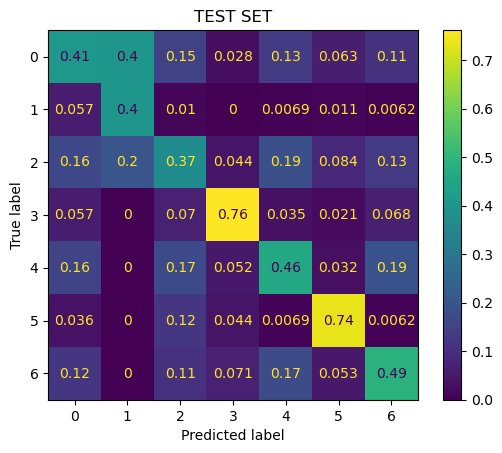

In [ ]:
# get production test set predictions 
y_true,y_pred = getPrediction(x_test,y_test)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'TEST SET')

We can see the results in the validation set are quite similar with the results in the test set , meaning the datasets have similar class frequencies (they are sampled up correctly) and the model has learned some features , in order to generalize.Of course we observe high TP only in class 3 (happy - most dominant class) and also class 5 (surprise) which in the test set has also relatively high frequency (100 samples).The other classes TP are close to 0.4-0.5 so we can deduce that the model can recover 75-76% correct happy and surprised samples but for the other classes it can only find close to half.In the rows we get the false positives for each class (each main diagonal element) and in the columns we get the false negatives for each class.


By sudying the confusion matrix we understand that probably fear and sadness can have similar image features with angry expressions and can therefore confuse the model .Also the class frequencies should be taken into account since those features are learned through training and a biased dataset with small variation can lead to those problems described above.

### We will use the sklearn balanced accuracy for imbalanced datasets to get an estimation on our model.


In [ ]:
model1_accuracy = sklearn.metrics.balanced_accuracy_score(y_true, y_pred)
print(model1_accuracy)

0.4841169058879919


The balanced accuracy is defined as the average of recall obtained on each class. It is therefore based on the recall rate which takes into account the TP and FN : how many of the actual true samples did we find and how many did we miss.The reported accuracy shows we have a long way to go in order to get a functional model.

# MORE ADVANCED CNN MODEL WITH DROPOUT AND BATCH NORMALIZATION

- Dropout is a technique that helps prevent overfitting .It works by selecting 'random' layers during training and zeroing some nodes inside them .This means their contribution on the next layer are eradicated and the model is therfore forced to try to learn features with more difficulty and thus it can generalize better.

- Batch Normalization on the other hand is a method to standardize the batches that are fed into the model for training.Batch normalization can be implemented during training by calculating the mean and standard deviation of each input for each layer per batch  and using them to perform the standardization.Alternately, a running average of mean and standard deviation can be calculated across batches but is less stable.Batch Normalization can help speed up the convergence of the model and the generalization ability of it since it works as a regularizer reducing overfitting.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

(None, 48, 48, 1)
<dtype: 'float32'>
(None, 48, 48, 64)
Model: "CNN-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_

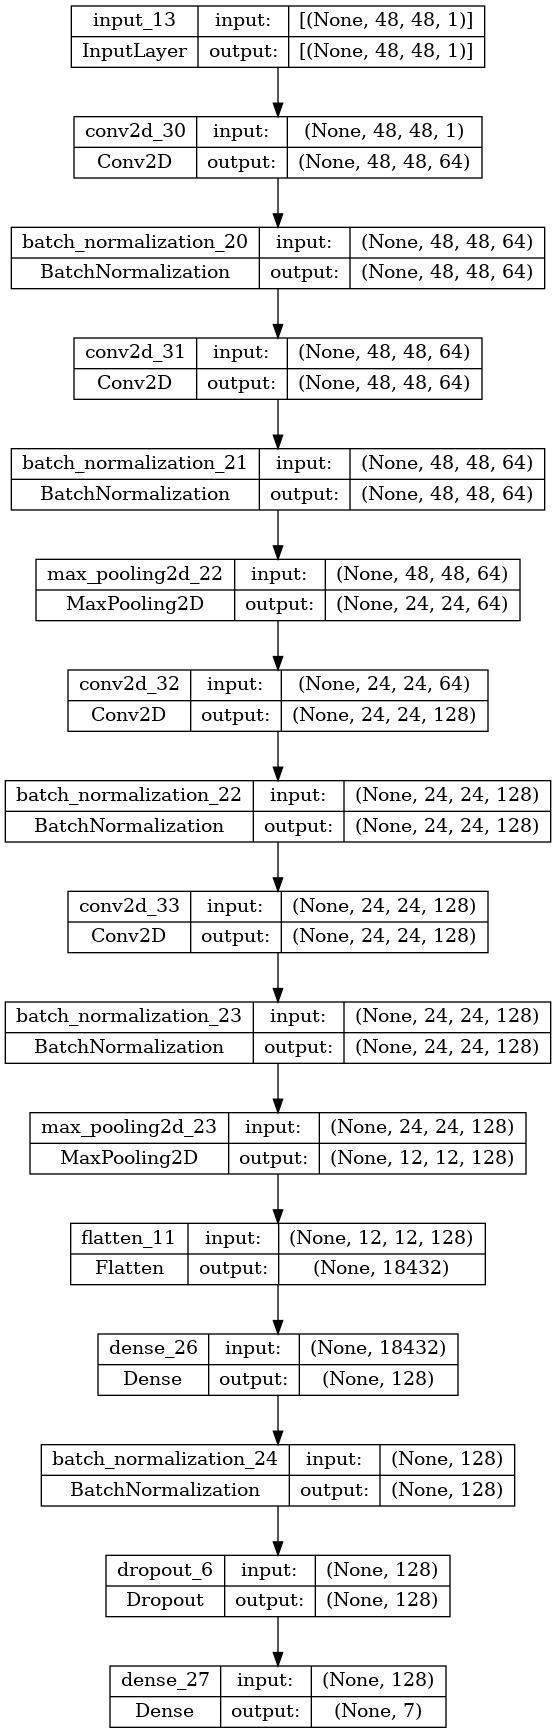

In [ ]:
# design the CNN

#functional api 
#0
inputs = keras.Input(shape=(48,48,1))
print(inputs.shape)
print(inputs.dtype)


#2 convolutional layer , test also other kernel sizes maybe (2,2),(4,4),(8,8),(16,16) /maybe also dilation rate
#apply convolution and pooling 
conv_layer2 = layers.Conv2D(64,(5,5),strides=(1,1),padding='same',activation='relu')
layer2_outputs = conv_layer2(inputs)
print(layer2_outputs.shape)
#add batch normalization
layer2b_outputs = layers.BatchNormalization()(layer2_outputs)


#3 convolutional layer
layer3_outputs = layers.Conv2D(64,(5,5),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer2b_outputs)
#batch normalization
layer3b_outputs = layers.BatchNormalization()(layer3_outputs)
# Max pooling
layer3d_outputs = layers.MaxPooling2D((2,2))(layer3b_outputs)
# Dropout
#layer3d_outputs = layers.Dropout(0.2)(layer3c_outputs)


#4 convolutional layer
layer4_outputs = layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu')(layer3d_outputs)
#batch normalization
layer4b_outputs = layers.BatchNormalization()(layer4_outputs)



#convolutional layer
layer5_outputs = layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer4b_outputs)
#batch normalization
layer5b_outputs = layers.BatchNormalization()(layer5_outputs)
# Max pooling
layer5d_outputs = layers.MaxPooling2D((2,2))(layer5b_outputs)
# Dropout
#layer5d_outputs = layers.Dropout(0.2)(layer5c_outputs)


#flatten the outputs of the previous layer and 
#add another fcn before feeding it to the final fcn - for classification
layer6_outputs= layers.Flatten()(layer5d_outputs)
layer6b_outputs = layers.Dense(128,activation = "relu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer6_outputs)



#add another last batch normalization layer  and dropout 
layer7_outputs= layers.BatchNormalization()(layer6b_outputs)
layer7b_outputs = layers.Dropout(0.4)(layer7_outputs)


#final layer 
outputs = layers.Dense(7,activation = "softmax")(layer7b_outputs)

#build model
cnn3 = keras.Model(inputs=inputs,outputs=outputs,name="CNN-3")
cnn3.summary()
keras.utils.plot_model(cnn3, "cnn3.png",show_shapes=True)

In [ ]:
# build model 3 
#train with 60 epochs
cnn3.compile(
loss=keras.losses.CategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
metrics=["accuracy"]
)

# reduce_learn_rate = same as before
# train_datagen  = same as before 
# we will use the same datagen  , lr scheduler , early stopping schema as before 
cnn_callback3 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True),
                 tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/cnn3.h5',save_best_only=True),
                reduce_learn_rate]

# augment train data 
train_datagen.fit(x_train)


#train model 3 
cnn3_history = cnn3.fit(train_datagen.flow(x_train,y_train,batch_size=32),
             validation_data=(x_val, y_val),
             steps_per_epoch=len(x_train)/32 ,epochs=100,callbacks=cnn_callback3)

Epoch 1/100
841/841 [==============================] - 26s 26ms/step - loss: 2.3763 - accuracy: 0.2276 - val_loss: 2.0219 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 21s 25ms/step - loss: 2.0207 - accuracy: 0.2836 - val_loss: 1.9476 - val_accuracy: 0.2932 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 21s 24ms/step - loss: 1.9077 - accuracy: 0.3369 - val_loss: 2.2141 - val_accuracy: 0.2319 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 21s 25ms/step - loss: 1.9221 - accuracy: 0.3611 - val_loss: 2.1422 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 21s 25ms/step - loss: 1.8832 - accuracy: 0.4051 - val_loss: 1.8048 - val_accuracy: 0.4549 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 20s 23ms/step - loss: 1.8757 - accuracy: 0.4373 - val_loss: 1.9242 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

## With this more advanced model we can achieve close to 63% accuracy .Let's plot the metrics and once again get the confusion matrices for our test and validation set.

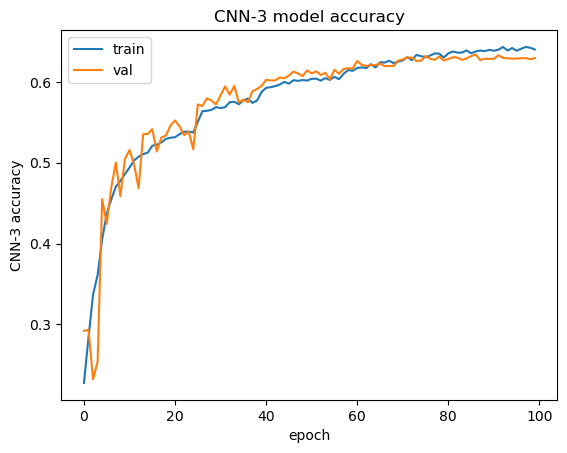

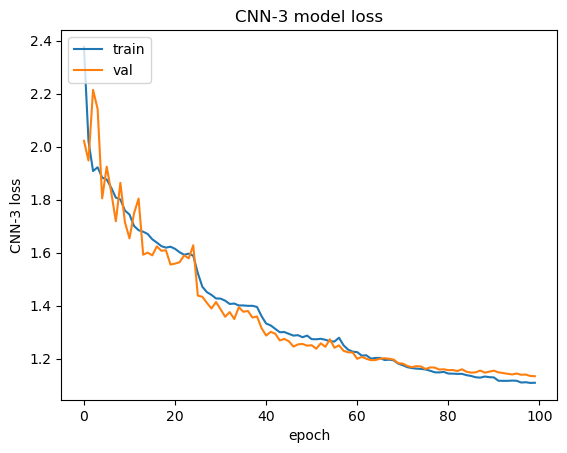

In [ ]:
getAccuracy(cnn3_history,'CNN-3')
getLoss(cnn3_history,'CNN-3')

253/253 [==============================] - 1s 5ms/step


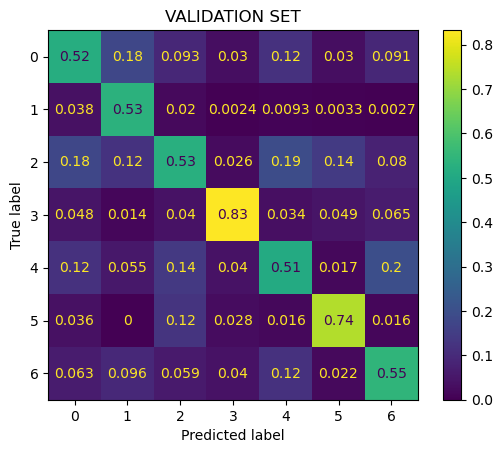

In [ ]:
# get production validation results
y_true,y_pred = getPrediction(cnn3,x_val,y_val)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'VALIDATION SET')

29/29 [==============================] - 0s 8ms/step


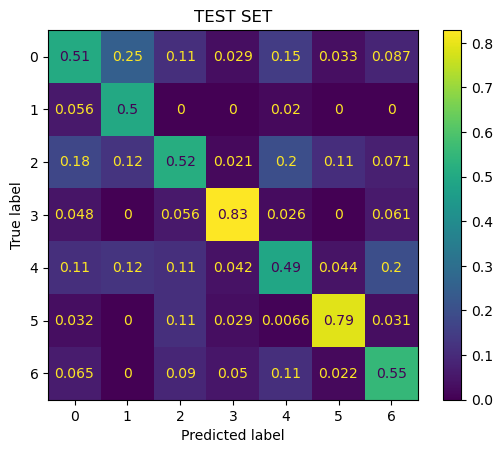

In [ ]:
# get production test set predictions 
y_true,y_pred = getPrediction(cnn3,x_test,y_test)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'TEST SET')

## By utilizing batch_normalization ,Dropout and using a more advanced model we see that the model accuracy has improved for all classes since more TP samples are recovered for all classes.Of course since the dataset is still not balanced the less represented classes still show greater FN and FP rate .

# **BALANCING THE DATASET AND ADDING MORE BATCH NORMALIZATION**

 - We will try to tackle the imbalance problem next, by lowering the samples of all classes to 3000 samples.We will combine this will data augmentation.
 - We will also add more Batch Normalization in the intermediate convolutional layers.

In [ ]:
#read the dataset again and split into individual dataset classes
#we create a dictionary holding all the data for each class
class_datasets = {}
k=7
for i in range(k):
    class_datasets[i]=faces[faces['emotion']==i]


In [ ]:
for it_v in class_datasets.items():
    print('The class' + str(it_v[0]) + ' has samples : ' + str(it_v[1].shape[0]))

The class0 has samples : 4953
The class1 has samples : 547
The class2 has samples : 5121
The class3 has samples : 8989
The class4 has samples : 6077
The class5 has samples : 4002
The class6 has samples : 6198


### now that we know the class samples let's downsample each class that has too many samples


In [ ]:
from sklearn.utils import resample
#class to implement up/down sampling 
class UpDownSampler:   
    #up/down sampling is achieved with the same function
    def reSample(self,dataset,n_samples):
        resample_dataset = resample(dataset,
             replace=True,
             n_samples=n_samples,
             random_state=42)
        print(resample_dataset.shape)
        return resample_dataset

## We will get 3000 samples from each class into our dataset and then split this new dataset into training,validation and testing.

In [ ]:
# let's create a new dictionary holding the resampled datasets
#in order to be able to do other sampling later 
resampled_class_datasets = {}
k=7
sampler1 = UpDownSampler()
for i in range(k):
    resampled_class_datasets[i]=sampler1.reSample(class_datasets[i],3000)

(3000, 3)
(3000, 3)
(3000, 3)
(3000, 3)
(3000, 3)
(3000, 3)
(3000, 3)


In [ ]:
#let's concatenate all the resampled class datasets to create a new merged dataset
resampled_total_dataset = pd.concat([ds for ds in resampled_class_datasets.values()])

In [ ]:
# test that indeed we have 3000 samples from each class
values = resampled_total_dataset['emotion'].value_counts()
print(values)

0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
Name: emotion, dtype: int64


In [ ]:

#same function as before to transform into tensors
def imageArray2(dataset,width,height):
    img1 = dataset['pixels'].iloc[0]
    array_img1 = np.array([float(x) for x in (list(img1.split(' ')))])
    print(array_img1.shape)
    image_array  = np.zeros((dataset.shape[0],array_img1.shape[0],1))
    i=0
    for img in dataset['pixels'][:]:
        image_array[i] =  np.array([float(x) for x in (list(img.split(' ')))]).reshape(-1,1)
        i=i+1
    #reshape into tensor of 2d images 
    image_array2d = np.reshape(image_array,(len(dataset['pixels']),width,height))
    print(image_array2d.shape)
    
    return image_array2d


#transform into image tensors
image_array2d = imageArray2(resampled_total_dataset,48,48)

(2304,)
(21000, 48, 48)


In [ ]:
image_labels,le = encodeClasses(resampled_total_dataset)
print(image_labels)


Classes encoded to [0, 1, 2, 3, 4, 5, 6]


Shape of image_labels (21000, 7)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


**We now split our new dataset and test that indeed we have equal class representation in all the datasets.**

In [ ]:
#split into training and validation set and test set 
x_train,x_val1,y_train,y_val1 = train_test_split(image_array2d,image_labels,train_size=0.75,random_state=42,stratify=image_labels,shuffle=True)
x_val,x_test,y_val,y_test = train_test_split(x_val1,y_val1,train_size=0.9,random_state=42,stratify=y_val1,shuffle=True)
#show the shapes 
x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape

((15750, 48, 48),
 (4725, 48, 48),
 (525, 48, 48),
 (15750, 7),
 (4725, 7),
 (525, 7))

In [ ]:
#check equal representation of all classes on all datasets
getClassesFreq(y_train)
getClassesFreq(y_val)
getClassesFreq(y_test)

[0 1 2 3 4 5 6]
[2250 2250 2250 2250 2250 2250 2250]
[0 1 2 3 4 5 6]
[675 675 675 675 675 675 675]
[0 1 2 3 4 5 6]
[75 75 75 75 75 75 75]


(array([0, 1, 2, 3, 4, 5, 6]), array([75, 75, 75, 75, 75, 75, 75]))

In [ ]:
#normalize images to get pixels in range (0,1)
x_train=x_train/255
x_val = x_val/255
x_test = x_test/255

In [ ]:
#flatten image for use in fcn
x_train_flattened = flatten2DImageMatrix(x_train)
x_val_flattened = flatten2DImageMatrix(x_val)
x_test_flattened = flatten2DImageMatrix(x_test)

(15750, 2304)
(4725, 2304)
(525, 2304)


# **READY TO TEST OUR RESAMPLED DATASET WITH THE MODELS WE HAVE CREATED** 
## - First we will test with the SIMPLE FCN model to check if we had any improvement , against our biased original dataset.
 

In [ ]:
fcn_model.compile(
loss=keras.losses.CategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(),
metrics=["accuracy"]
)

bal_history = fcn_model.fit(x_train_flattened,y_train,batch_size=32,epochs=100,verbose=2,validation_data=(x_val_flattened,y_val))

Epoch 1/100
493/493 - 4s - loss: 1.5563 - accuracy: 0.4150 - val_loss: 1.4337 - val_accuracy: 0.4576 - 4s/epoch - 8ms/step
Epoch 2/100
493/493 - 2s - loss: 1.4918 - accuracy: 0.4366 - val_loss: 1.5116 - val_accuracy: 0.4252 - 2s/epoch - 4ms/step
Epoch 3/100
493/493 - 2s - loss: 1.4640 - accuracy: 0.4439 - val_loss: 1.5029 - val_accuracy: 0.4226 - 2s/epoch - 4ms/step
Epoch 4/100
493/493 - 2s - loss: 1.4475 - accuracy: 0.4488 - val_loss: 1.4842 - val_accuracy: 0.4499 - 2s/epoch - 4ms/step
Epoch 5/100
493/493 - 2s - loss: 1.4213 - accuracy: 0.4614 - val_loss: 1.4408 - val_accuracy: 0.4480 - 2s/epoch - 4ms/step
Epoch 6/100
493/493 - 2s - loss: 1.3920 - accuracy: 0.4757 - val_loss: 1.4258 - val_accuracy: 0.4616 - 2s/epoch - 4ms/step
Epoch 7/100
493/493 - 2s - loss: 1.3603 - accuracy: 0.4905 - val_loss: 1.4744 - val_accuracy: 0.4392 - 2s/epoch - 4ms/step
Epoch 8/100
493/493 - 2s - loss: 1.3520 - accuracy: 0.4903 - val_loss: 1.4517 - val_accuracy: 0.4544 - 2s/epoch - 4ms/step
Epoch 9/100
493/

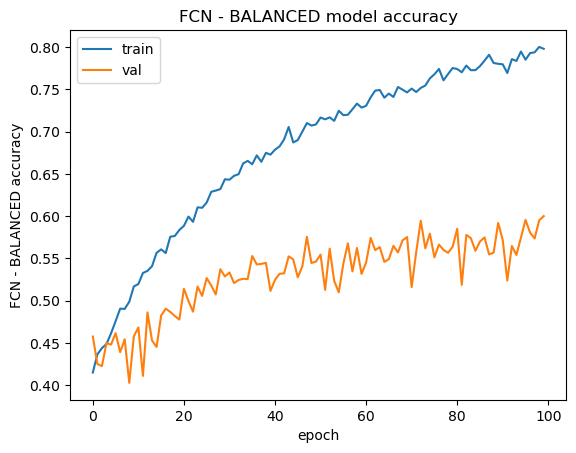

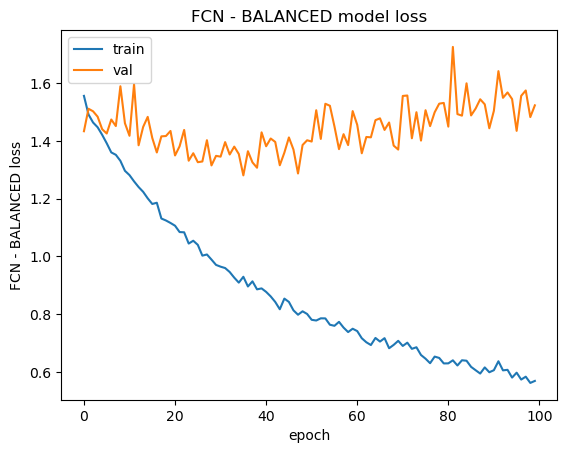

In [ ]:
getAccuracy(bal_history,'FCN - BALANCED')
getLoss(bal_history,'FCN - BALANCED')

### We observe that the model has improved ! Nevertheless , since trainining starts with relativley high accuracy this can mean the datasets are very similar now -we know by construction they have same class frequency- (not always a good thing since it is a form of overfitting if the patterns in validation and training set are very similar).By observing the validation loss plot we can see overfitting after epoch ~45-50 so it is possible the improvement to be close to +5 in the accuracy of the olde model (close to 54-55%).This fcn model is used only to make some observations and will not be the production model .

# **Next we will use the new balanced dataset to train our cnn models that we built before**

In [ ]:
#transform the images in 2d matrices (actually tensors of width x hight x 1)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1], x_train.shape[1],1))
print(x_train.shape)
x_val=np.reshape(x_val,(x_val.shape[0],x_val.shape[1],x_val.shape[1],1))
print(x_val.shape)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[1],1))
print(x_test.shape)

(15750, 48, 48, 1)
(4725, 48, 48, 1)
(525, 48, 48, 1)


In [ ]:
cnn_callback2_bal = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True,verbose=1),
                 tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/cnn2_bal.h5',save_best_only=True),
                reduce_learn_rate]

cnn2.reset_states()
cnn2_bal_history = cnn2.fit(train_datagen.flow(x_train,y_train,batch_size=32),
             validation_data=(x_val, y_val),
             steps_per_epoch=len(x_train)/32 ,epochs=100,callbacks=cnn_callback2_bal,verbose=1)

Epoch 1/100
492/492 [==============================] - 9s 19ms/step - loss: 1.3442 - accuracy: 0.4954 - val_loss: 1.2155 - val_accuracy: 0.5403 - lr: 1.5625e-05
Epoch 2/100
492/492 [==============================] - 9s 18ms/step - loss: 1.3017 - accuracy: 0.5103 - val_loss: 1.2071 - val_accuracy: 0.5473 - lr: 1.5625e-05
Epoch 3/100
492/492 [==============================] - 9s 19ms/step - loss: 1.2954 - accuracy: 0.5116 - val_loss: 1.2033 - val_accuracy: 0.5496 - lr: 1.5625e-05
Epoch 4/100
492/492 [==============================] - 9s 18ms/step - loss: 1.2888 - accuracy: 0.5145 - val_loss: 1.2043 - val_accuracy: 0.5517 - lr: 1.5625e-05
Epoch 5/100
492/492 [==============================] - 9s 18ms/step - loss: 1.2937 - accuracy: 0.5103 - val_loss: 1.2016 - val_accuracy: 0.5539 - lr: 1.5625e-05
Epoch 6/100
492/492 [==============================] - 10s 19ms/step - loss: 1.2969 - accuracy: 0.5111 - val_loss: 1.2005 - val_accuracy: 0.5534 - lr: 1.5625e-05
Epoch 7/100
492/492 [============

# LET'S TEST THE ADVANCED CNN MODEL IN OUR RESAMPLED DATASET NOW 

### We will try our more advanced model but first we will add some more batch normalization and some more convolutional layers.In this phase we also add regularizers into the cnn layers , which help prevent overfitting by limiting the 'norms' .

(None, 48, 48, 1)
<dtype: 'float32'>
(None, 48, 48, 64)
Model: "CNN-3-BALANCED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_191 (Conv2D)         (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_204 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_192 (Conv2D)         (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_205 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                              

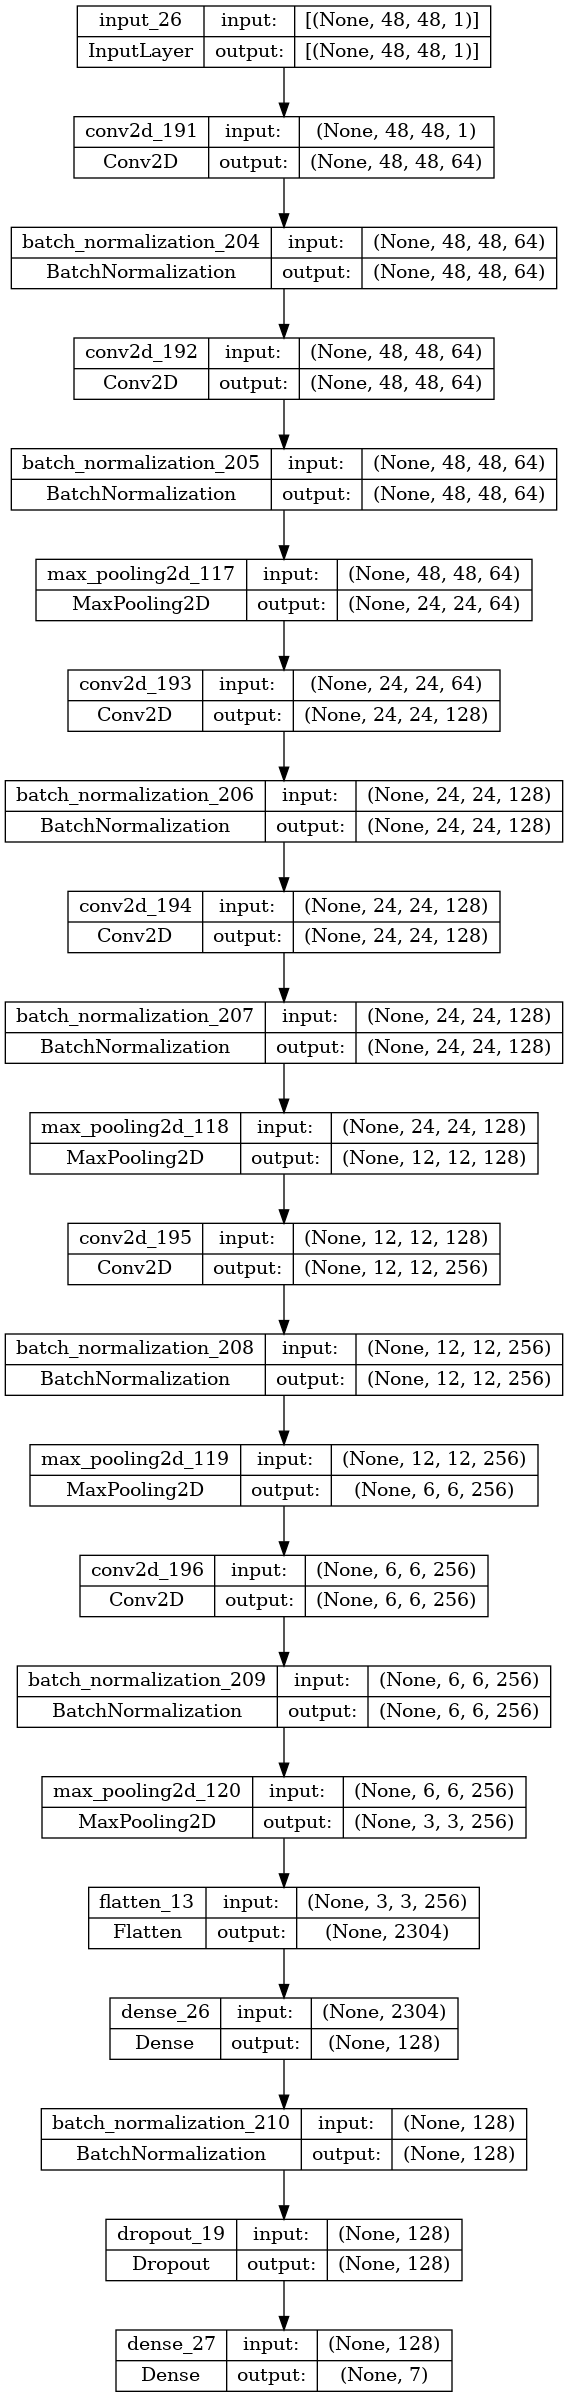

In [ ]:
# design the CNN

#functional api 
#0
inputs = keras.Input(shape=(48,48,1))
print(inputs.shape)
print(inputs.dtype)


#2 convolutional layer , test also other kernel sizes maybe (2,2),(4,4),(8,8),(16,16) /maybe also dilation rate
#apply convolution and pooling 
conv_layer2 = layers.Conv2D(64,(5,5),strides=(1,1),padding='same',activation='relu')
layer2_outputs = conv_layer2(inputs)
print(layer2_outputs.shape)
#add batch normalization
layer2b_outputs = layers.BatchNormalization()(layer2_outputs)


#3 convolutional layer
layer3_outputs = layers.Conv2D(64,(5,5),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer2b_outputs)
#batch normalization
layer3b_outputs = layers.BatchNormalization()(layer3_outputs)
# Max pooling
layer3d_outputs = layers.MaxPooling2D((2,2))(layer3b_outputs)
# Dropout
#layer3d_outputs = layers.Dropout(0.2)(layer3c_outputs)


#4 convolutional layer
layer4_outputs = layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu')(layer3d_outputs)
#batch normalization
layer4b_outputs = layers.BatchNormalization()(layer4_outputs)



#convolutional layer
layer5_outputs = layers.Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer4b_outputs)
#batch normalization
layer5b_outputs = layers.BatchNormalization()(layer5_outputs)
# Max pooling
layer5d_outputs = layers.MaxPooling2D((2,2))(layer5b_outputs)
# Dropout
#layer5d_outputs = layers.Dropout(0.2)(layer5c_outputs)



#convolutional layer
layer5e_outputs = layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer5d_outputs)
#batch normalization
layer5f_outputs = layers.BatchNormalization()(layer5e_outputs)
# Max pooling
layer5g_outputs = layers.MaxPooling2D((2,2))(layer5f_outputs)


#convolutional layer 
layer5h_outputs = layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer5g_outputs)
#batch normalization
layer5i_outputs = layers.BatchNormalization()(layer5h_outputs)
# Max pooling
layer5j_outputs = layers.MaxPooling2D((2,2))(layer5i_outputs)



#flatten the outputs of the previous layer and 
#add another fcn before feeding it to the final fcn - for classification
layer6_outputs= layers.Flatten()(layer5j_outputs)
layer6b_outputs = layers.Dense(128,activation = "relu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer6_outputs)



#add another last batch normalization layer  and dropout 
layer7_outputs= layers.BatchNormalization()(layer6b_outputs)
layer7b_outputs = layers.Dropout(0.4)(layer7_outputs)


#final layer 
outputs = layers.Dense(7,activation = "softmax")(layer7b_outputs)

#build model
cnn3_bal = keras.Model(inputs=inputs,outputs=outputs,name="CNN-3-BALANCED")
cnn3_bal.summary()
keras.utils.plot_model(cnn3_bal, "cnn3_bal.png",show_shapes=True)


In [ ]:
cnn3_bal.compile(
loss=keras.losses.CategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
metrics=["accuracy"]
)

In [ ]:
# callbacks #
reduce_learn_rate=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6, #0.2, #0.5
    patience=5,
    verbose=1,
    min_lr=1e-10 #-7
)

train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.12,
    horizontal_flip=True,
    vertical_flip=True
)

cnn_bal_callback3 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True),
                 tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/cnn3_bal.h5',save_best_only=True),
                reduce_learn_rate]

In [ ]:
train_datagen.fit(x_train)
#train model 3 
cnn3_bal_history = cnn3_bal.fit(train_datagen.flow(x_train,y_train,batch_size=32),
             validation_data=(x_val, y_val),
             steps_per_epoch=len(x_train)/32 ,epochs=100,callbacks=cnn_bal_callback3)


Epoch 1/100
492/492 [==============================] - 18s 27ms/step - loss: 2.5973 - accuracy: 0.1747 - val_loss: 2.3884 - val_accuracy: 0.1683 - lr: 0.0010
Epoch 2/100
492/492 [==============================] - 14s 28ms/step - loss: 2.3670 - accuracy: 0.1999 - val_loss: 2.2134 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 3/100
492/492 [==============================] - 12s 25ms/step - loss: 2.1851 - accuracy: 0.2670 - val_loss: 2.1126 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 4/100
492/492 [==============================] - 13s 27ms/step - loss: 2.0370 - accuracy: 0.3382 - val_loss: 2.3509 - val_accuracy: 0.2358 - lr: 0.0010
Epoch 5/100
492/492 [==============================] - 12s 25ms/step - loss: 1.9203 - accuracy: 0.3940 - val_loss: 1.9625 - val_accuracy: 0.3731 - lr: 0.0010
Epoch 6/100
492/492 [==============================] - 13s 26ms/step - loss: 1.8461 - accuracy: 0.4376 - val_loss: 2.0283 - val_accuracy: 0.3604 - lr: 0.0010
Epoch 7/100
492/492 [==============================]

# **The model seems to have improved a lot but in order to be certain we need to plot the accuracy , loss and the confusion matrices on the test and validation datasets**.

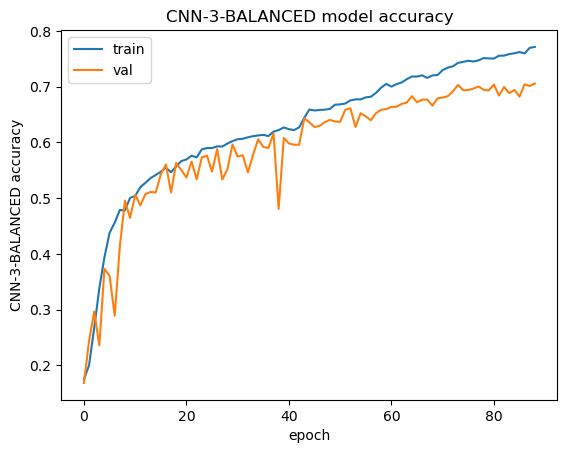

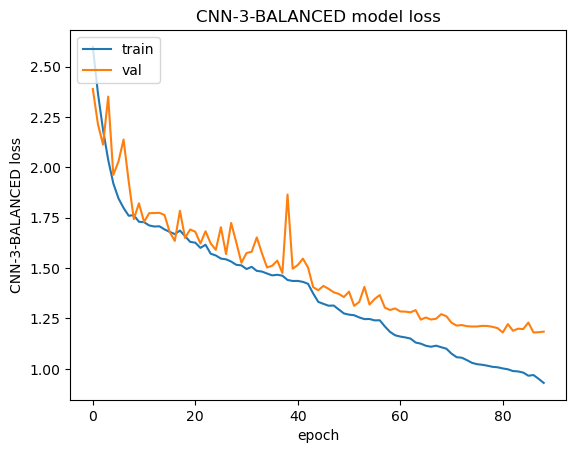

In [ ]:
getAccuracy(cnn3_bal_history,'CNN-3-BALANCED')
getLoss(cnn3_bal_history,'CNN-3-BALANCED')

148/148 [==============================] - 1s 6ms/step


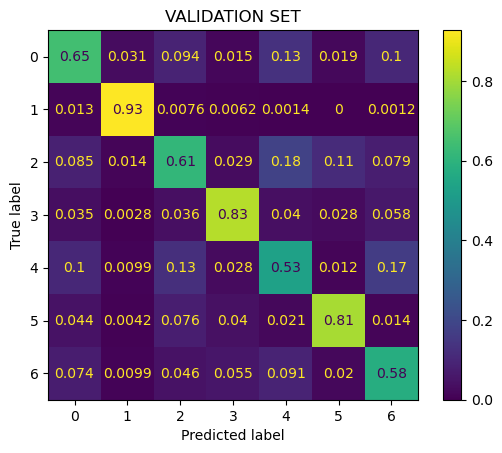

In [ ]:
# get production validation results
y_true,y_pred = getPrediction(cnn3_bal,x_val,y_val)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'VALIDATION SET')

17/17 [==============================] - 0s 18ms/step


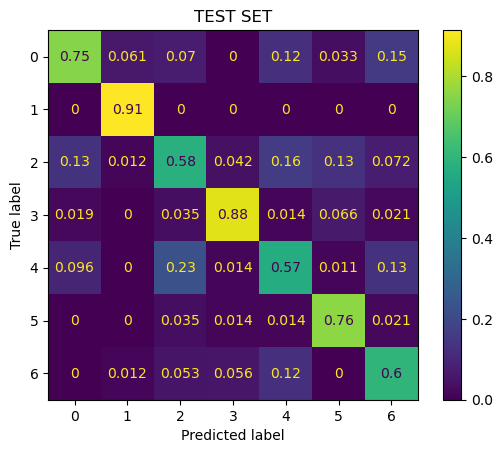

In [ ]:
# get production test set predictions 
y_true,y_pred = getPrediction(cnn3_bal,x_test,y_test)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'TEST SET')

#### **CHEERS ! Making the model more complex in combination with regularization , more augmentation and of course equal sampling led  to the recognition of more discriminating features of the 'emotion' images and thus the model can now recover more TP samples.We still have FP and FN for many classes but at least the model manages to find more samples now.**

# Next we will try adding more variation in our image datagen 
- maybe more filters
- maybe more batch normalization

(None, 48, 48, 1)
<dtype: 'float32'>
(None, 48, 48, 64)
Model: "CNN-4-BALANCED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_183 (Conv2D)         (None, 48, 48, 64)        3200      
                                                                 
 batch_normalization_195 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_184 (Conv2D)         (None, 48, 48, 64)        200768    
                                                                 
 batch_normalization_196 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                              

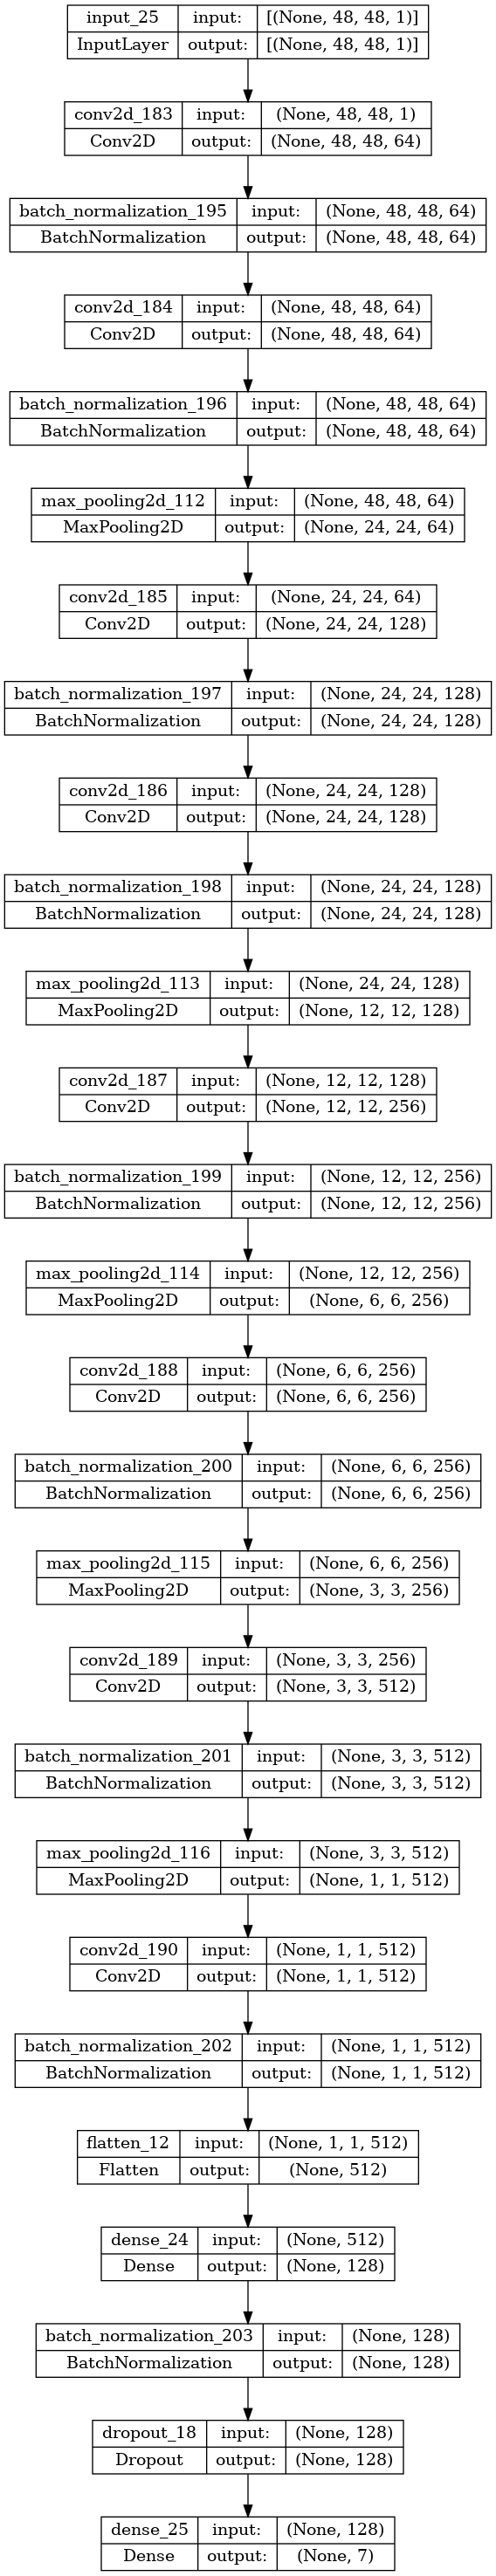

In [ ]:
# design the CNN

#functional api 
#0
inputs = keras.Input(shape=(48,48,1))
print(inputs.shape)
print(inputs.dtype)


#2 convolutional layer , test also other kernel sizes maybe (2,2),(4,4),(8,8),(16,16) /maybe also dilation rate
#apply convolution and pooling 
conv_layer2 = layers.Conv2D(64,(7,7),strides=(1,1),padding='same',activation='relu')
layer2_outputs = conv_layer2(inputs)
print(layer2_outputs.shape)
#add batch normalization
layer2b_outputs = layers.BatchNormalization()(layer2_outputs)


#3 convolutional layer
layer3_outputs = layers.Conv2D(64,(7,7),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer2b_outputs)
#batch normalization
layer3b_outputs = layers.BatchNormalization()(layer3_outputs)
# Max pooling
layer3d_outputs = layers.MaxPooling2D((2,2))(layer3b_outputs)
# Dropout
#layer3d_outputs = layers.Dropout(0.2)(layer3c_outputs)


#4 convolutional layer
layer4_outputs = layers.Conv2D(128,(5,5),strides=(1,1),padding='same',activation='relu')(layer3d_outputs)
#batch normalization
layer4b_outputs = layers.BatchNormalization()(layer4_outputs)



#convolutional layer
layer5_outputs = layers.Conv2D(128,(5,5),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer4b_outputs)
#batch normalization
layer5b_outputs = layers.BatchNormalization()(layer5_outputs)
# Max pooling
layer5d_outputs = layers.MaxPooling2D((2,2))(layer5b_outputs)
# Dropout
#layer5d_outputs = layers.Dropout(0.2)(layer5c_outputs)



#convolutional layer
layer5e_outputs = layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer5d_outputs)
#batch normalization
layer5f_outputs = layers.BatchNormalization()(layer5e_outputs)
# Max pooling
layer5g_outputs = layers.MaxPooling2D((2,2))(layer5f_outputs)


#convolutional layer 
layer5h_outputs = layers.Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer5g_outputs)
#batch normalization
layer5i_outputs = layers.BatchNormalization()(layer5h_outputs)
# Max pooling
layer5j_outputs = layers.MaxPooling2D((2,2))(layer5i_outputs)



#convolutional layer 
layer5k_outputs = layers.Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer5j_outputs)
#batch normalization
layer5l_outputs = layers.BatchNormalization()(layer5k_outputs)
# Max pooling
layer5m_outputs = layers.MaxPooling2D((2,2))(layer5l_outputs)


#convolutional layer  #1024
layer5n_outputs = layers.Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer5m_outputs)
#batch normalization
layer5q_outputs = layers.BatchNormalization()(layer5n_outputs)




#flatten the outputs of the previous layer and 
#add another fcn before feeding it to the final fcn - for classification
layer6_outputs= layers.Flatten()(layer5q_outputs)
layer6b_outputs = layers.Dense(128,activation = "relu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(layer6_outputs)



#add another last batch normalization layer  and dropout 
layer7_outputs= layers.BatchNormalization()(layer6b_outputs)
layer7b_outputs = layers.Dropout(0.4)(layer7_outputs) #dropout 0.4


#final layer 
outputs = layers.Dense(7,activation = "softmax")(layer7b_outputs)

#build model
cnn4_bal = keras.Model(inputs=inputs,outputs=outputs,name="CNN-4-BALANCED")
cnn4_bal.summary()
keras.utils.plot_model(cnn4_bal, "cnn4_bal.png",show_shapes=True)


In [ ]:
cnn4_bal.compile(
loss=keras.losses.CategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
metrics=["accuracy"]
)

#lr 0.001 

# callbacks #
reduce_learn_rate=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6, # 0.6 #0.2, #0.5
    patience=5,
    verbose=1,
    min_lr=1e-10 #-7
)

train_datagen = image.ImageDataGenerator(
    rotation_range=20,     #10
    width_shift_range=0.2, #0.15
    height_shift_range=0.2, #0.15
    shear_range=0.15,        #0.12
    horizontal_flip=True,
    vertical_flip=True
)

cnn_bal_callback4 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True),
                 tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/cnn4_bal.h5',save_best_only=True),
                reduce_learn_rate]


cnn4_bal.reset_states()
train_datagen.fit(x_train)
#train model 3 
cnn4_bal_history = cnn4_bal.fit(train_datagen.flow(x_train,y_train,batch_size=32),
             validation_data=(x_val, y_val),
             steps_per_epoch=len(x_train)/32 ,epochs=150,callbacks=cnn_bal_callback4,verbose=1)


Epoch 1/150
492/492 [==============================] - 26s 38ms/step - loss: 2.9081 - accuracy: 0.1633 - val_loss: 2.5905 - val_accuracy: 0.1655 - lr: 0.0010
Epoch 2/150
492/492 [==============================] - 18s 36ms/step - loss: 2.6239 - accuracy: 0.1771 - val_loss: 2.4831 - val_accuracy: 0.1856 - lr: 0.0010
Epoch 3/150
492/492 [==============================] - 19s 38ms/step - loss: 2.4883 - accuracy: 0.1841 - val_loss: 2.3829 - val_accuracy: 0.2239 - lr: 0.0010
Epoch 4/150
492/492 [==============================] - 18s 36ms/step - loss: 2.3553 - accuracy: 0.2082 - val_loss: 2.3393 - val_accuracy: 0.2436 - lr: 0.0010
Epoch 5/150
492/492 [==============================] - 16s 33ms/step - loss: 2.2299 - accuracy: 0.2486 - val_loss: 2.7375 - val_accuracy: 0.1528 - lr: 0.0010
Epoch 6/150
492/492 [==============================] - 18s 37ms/step - loss: 2.1415 - accuracy: 0.2821 - val_loss: 2.0676 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 7/150
492/492 [==============================]

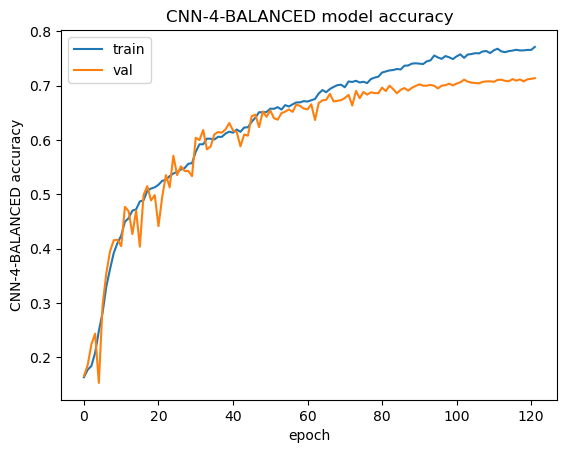

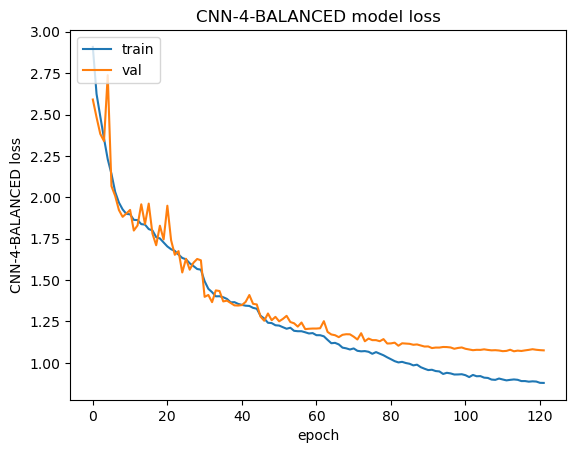

In [ ]:
getAccuracy(cnn4_bal_history,'CNN-4-BALANCED')
getLoss(cnn4_bal_history,'CNN-4-BALANCED')

148/148 [==============================] - 1s 8ms/step


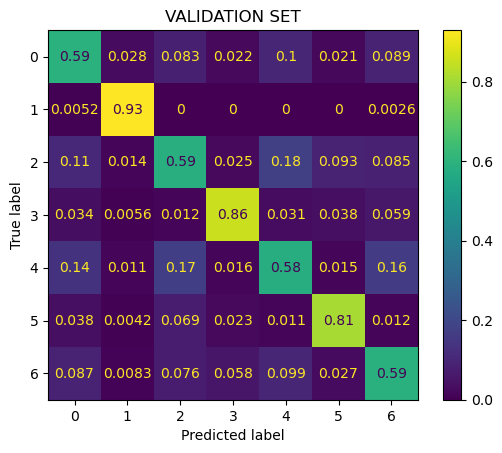

In [ ]:
# get production validation results
y_true,y_pred = getPrediction(cnn4_bal,x_val,y_val)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'VALIDATION SET')

17/17 [==============================] - 1s 31ms/step


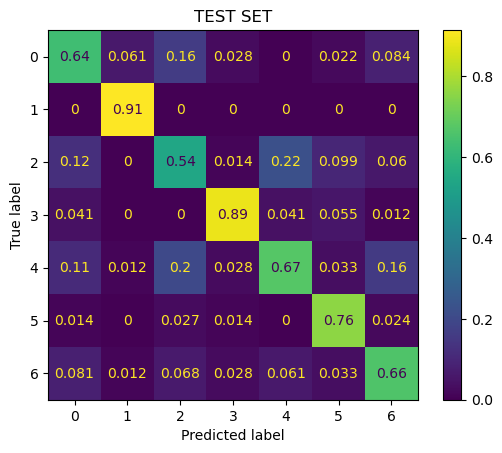

In [ ]:
# get production test set predictions 
y_true,y_pred = getPrediction(cnn4_bal,x_test,y_test)

#confusion matrix for test set predictions
conf_mat = plotConfusionMatrix(y_true,y_pred,[0,1,2,3,4,5,6],'TEST SET')

### The TP and TN rate have increased for most classes but still class 2 (fear) has low TP/TN rate.In order to combat this , fusion - multimodal models would be needed.This way a more complex feature extraction would take place and the recognition of the discriminating features of the emotions would be easier.



# Predicting user given batches of images

Next we construct a class to take care of preprocessing and apply the model into batches of data given by the user 

In [ ]:
#class image_Processer
import os 


class samplePreprocessing:
    def __init__(self,name,model):
        self.name = name
        self.model = model
        self.batches2d = []
        
    # this method is intended to feed new batches of photos for prediction
    def feedData(self,basepath):
        # PHASE A: READ BATCHES OF PHOTOS AVAILABLE #
        #basepath = '/content/drive/MyDrive/MACHINE_LEARNING_2/DATA/1.jpg'
        data_upt = [img for img in os.listdir(basepath)]
        batches = []
        for frame in data_upt:
                frame2 = cv2.imread(basepath + frame ,cv2.IMREAD_GRAYSCALE)
                frame3 =  cv2.resize(frame2, (48, 48))
                frame4 = (frame3.astype('float64') )/255.0
                frame4=np.reshape(frame4,(1,48, 48,1))
                batches.append(frame4)
                # keep a list to grab the 2d image in case of display before prediction 
                self.batches2d.append(frame3)

        batch_array = np.zeros((len(batches),48,48,1))
        i=0
        for i,v in enumerate(batches):
            batch_array[i]=v
        return batch_array


    # this method is intended to feed new  photos for prediction
    def feedSingle(self,frame2):
                #frame2 = cv2.imread(basepath + frame ,cv2.IMREAD_GRAYSCALE)
                frame3 =  cv2.resize(frame2, (48, 48))
                frame4 = (frame3.astype('float64') )/255.0
                frame4=np.reshape(frame4,(1,48, 48,1))
                print('\n ---PREDICTING THE FOLLOWING IMAGE--- : \n')
                prediction = self.model.predict(frame4)
                prediction = np.argmax( prediction)
                #plt.imshow(self.batches2d[ind],cmap='gray')
                image2 = cv2.putText(img=frame3, text=emotion_dict[prediction],org=(5,10),  fontFace = cv2.FONT_HERSHEY_DUPLEX ,fontScale=0.28,color=(255,150,0) , thickness=1, lineType=cv2.LINE_AA)
                plt.figure()
                plt.imshow(image2,cmap='gray')
                return prediction

    
    # make predictions on batches of images dataset
    def predictBatches(self,test_batch,ind):
        print('\n ---PREDICTING THE FOLLOWING IMAGE--- : \n')
        prediction = self.model.predict(test_batch[ind][None,...])
        prediction = np.argmax( prediction)
        #plt.imshow(self.batches2d[ind],cmap='gray')
        image2 = cv2.putText(img=self.batches2d[ind], text=emotion_dict[prediction],org=(5,10),  fontFace = cv2.FONT_HERSHEY_DUPLEX ,fontScale=0.28,color=(255,150,0) , thickness=1, lineType=cv2.LINE_AA)
        plt.imshow(image2,cmap='gray')
        return prediction
    
        

In [ ]:
# since i trained the model on kaggle i downloaded the model and saved it in the drive, the training was pretty slow so i figured i would spare some time
# of course this latest model is the last one trained : cnn4_bal.h5 , so you can train it as well 

#load the latest model and use it to predict on the new photos next 
# you can use this link to load the available models including model ccn4_bal : 
# https://drive.google.com/drive/folders/18uv5VDxadkwZU59ruERE8Et4C7MygMaF?usp=sharing
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MACHINE_LEARNING_2/MODELS/cnn4_bal.h5')
new_model.summary()


Model: "CNN-4-BALANCED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_183 (Conv2D)         (None, 48, 48, 64)        3200      
                                                                 
 batch_normalization_195 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_184 (Conv2D)         (None, 48, 48, 64)        200768    
                                                                 
 batch_normalization_196 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 24, 24, 64)    

**Next , we read some user's photos and apply the model in a production environment.The predictions are made by giving the index of the image as a parameter into the class method.**

In [ ]:
prepro = samplePreprocessing('PREDICTION_ON_USER_PHOTOS',new_model)
batches = prepro.feedData('/content/drive/MyDrive/MACHINE_LEARNING_2/DATA/PHOTOS/')
#prediction = prepro.predictBatches(batches,6)
#print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )


 ---PREDICTING THE FOLLOWING IMAGE--- : 

1/1 [==============================] - 8s 8s/step
--- The model says the given face has the emotion of class :  5/surprise


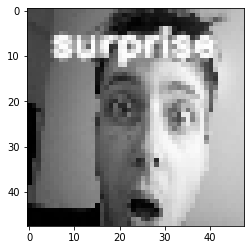

In [ ]:
prediction = prepro.predictBatches(batches,6)
print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )


 ---PREDICTING THE FOLLOWING IMAGE--- : 

1/1 [==============================] - 0s 25ms/step
--- The model says the given face has the emotion of class :  2/fear


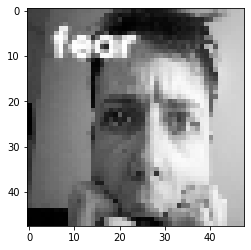

In [ ]:
prediction = prepro.predictBatches(batches,2)
print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )


 ---PREDICTING THE FOLLOWING IMAGE--- : 

1/1 [==============================] - 0s 30ms/step
--- The model says the given face has the emotion of class :  6/neutral


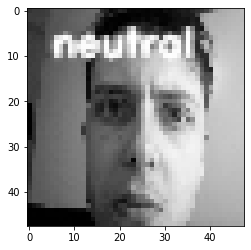

In [ ]:
prediction = prepro.predictBatches(batches,3)
print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )


 ---PREDICTING THE FOLLOWING IMAGE--- : 

1/1 [==============================] - 0s 26ms/step
--- The model says the given face has the emotion of class :  0/anger


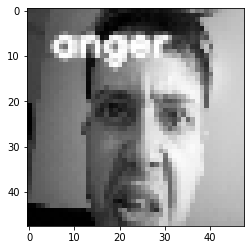

In [ ]:
prediction = prepro.predictBatches(batches,4)
print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )

We can see that the model predicted 3/4 images correctly.Also it makes sense that the 'sad' face was mistaken for an angry face since we observed from the confusion matrix that 67% of the TP are found so we have 33% chance the model will not find all the correct sad faces.In comparison we can estimate that 89% of the happy samples will be recovered.Of course the model can get confused if some faces are similar to each other and tests showed that 'disgust' and 'angry' faces are very similar leading to missclassifications.

**Another important factor playing a significant role in the accuracy of the model is the annotation of the classes of the original dataset.More specifically the 'fer - 2013 ' dataset is a notoriously problematic dataset since the annotations were made by a few people and include a lot of subjectivity.Since then better datasets have been published 'ck+' , 'fer+' and also fusion methods have been proposed , which can improve the accuracy to 90+ %.**

# Live Capture Prediction #

**Next we use the following 2 scripts to capture from live camera using the button 'capture' and feed each frame to the model .The model does the prediction and returns the image and the class it predicted.**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

**Capture from live camera and feed to the model to get the prediction by running the following script.The user presses capture to capure the photo and the model shows the prediction.**

In [ ]:
from IPython.display import Image
while(1):
    try:
      filename = take_photo()
      print('Saved to {}'.format(filename))
      
      # Show the image which was just taken.
      display(Image(filename))

      photo = cv2.imread(filename ,cv2.IMREAD_GRAYSCALE)
      #photo = cv2.cvtColor(current_frame[1], cv2.COLOR_BGR2GRAY)
      prediction = prepro.feedSingle(photo)
      print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )
      


    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))

# Offline continuous ~0.2 fps Implementation

Next we present an offline implementation that the user can utilize in order to run the model locally ,
take pictures and get the resultng predictions.The script opens the camera after 5 seconds , takes a picture then closes the camera and after 5 seconds it repeats the process.(So the latency is close to 5-10 sconds in total).
The fps can easily be customized of course in order to be faster.(The on-off pattenr was utilized in order to give a visual cue to the user)

required packages for python :
- tensorflow
- os
- opencv
- time
- matplotlib
- numpy
- IPython 
Also the load_model (..path..) should change to where the user has saved the model.
The script was tested on Ubuntu 20.04 in the Spyser ide.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 01:58:53 2023

@author: st_ko
"""


import cv2 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import time

import os 
from IPython import get_ipython


#get_ipython().run_line_magic('matplotlib', 'qt')
get_ipython().run_line_magic('matplotlib', 'inline')

#create the classes dictionary 
emotion_dict = {0:'anger',
                1:'disgust',
                2:'fear',
                3:'happiness',
                4:'sadness',
                5:'surprise',
                6:'neutral' }





class samplePreprocessing:
    def __init__(self,name,model):
        self.name = name
        self.model = model
        #self.batches2d = None
        
    # this method is intended to feed new batches of photos for prediction
    def feedData(self,frame2):
                frame3 =  cv2.resize(frame2, (48, 48))
                frame4 = (frame3.astype('float64') )/255.0
                frame4=np.reshape(frame4,(1,48, 48,1))
                
                print('\n ---PREDICTING THE FOLLOWING IMAGE--- : \n')
                prediction = self.model.predict(frame4)
                prediction = np.argmax( prediction)
                #plt.imshow(self.batches2d[ind],cmap='gray')
                image2 = cv2.putText(img=frame3, text=emotion_dict[prediction],org=(5,10),  fontFace = cv2.FONT_HERSHEY_DUPLEX ,fontScale=0.28,color=(255,150,0) , thickness=1, lineType=cv2.LINE_AA)
                #plt.figure()
                plt.imshow(image2,cmap='gray')
                return prediction

        

if __name__ == '__main__':
    # load saved model ans print summary
    new_model = tf.keras.models.load_model('/home/st_ko/Desktop/Machine_Learning_Ex2/Latest_models2/cnn4_bal.h5')
    new_model.summary()
    prepro = samplePreprocessing('PREDICTION_ON_USER_PHOTOS',new_model)
    cam1 = cv2.VideoCapture(0)
    cam1.open('/dev/video0')
    assert cam1.isOpened()==True
    
    #set framerate 
    cam1.set(cv2.CAP_PROP_FPS,0.2)
    
    print("---Camera is starting in 5 seconds---")
    #time.sleep(5)
    
    count = 0 
    while(1):
        cam1.release()
        time.sleep(3)
       
        #capture frames
        start=time.time()
        cam1.open('/dev/video0')
        current_frame = cam1.read()
        
        # turn into grayscale 
        photo = cv2.cvtColor(current_frame[1], cv2.COLOR_BGR2GRAY)
        prediction = prepro.feedData(photo)
        print('--- The model says the given face has the emotion of class : ' , str(prediction) +'/' + emotion_dict[prediction] )
        time.sleep(5)
      
    #close camera after motion classification is done
    #maybe add button for user to close it 
    cam1.release()
    cam1.close()
    
    
